# Thermal Infrared Remote Sensing of Snow

:::{admonition} Learning Objectives

**At the conclusion of this tutorial, you will be able to:**
- understand the differences between sources of thermal IR observations, the advantages and disadvantages of each, and types of research questions we can address with those observations
- visualize point and raster thermal infrared datasets together, then compute error statistics between point and raster datasets
- access and visualize airborne and satellite thermal infrared imagery, then scale imagery of different spatial resolutions for comparison

:::

## Why do we want thermal images of snow?

Observations of snow surface temperature can tell us about the energy state of the snowpack, and tell us when the surface reaches melting point. The surface temperature is also the lower boundary layer for turbulent energy fluxes. We can use observations of snow surface temperature as a diagnostic tool to assess how well snow models represent this energy balance and the onset of snowmelt.

<figure>
  <img src="figures/snow_temp_graph.png" width="600"/>
  <figcaption>Example of snow depth over time illustrating snow temperature at different depths with colorbar.<br/>(Figure by Jessica Lundquist)</figcaption>
</figure>

Images of snow surface temperature from satellites or aircraft, rather than temperature measurements taken a single point on the ground, can provide insight into the snow surface energy balance at a point in time across a large area such as an entire watershed.

Many satellite remote sensing imagers you may already be familiar with include thermal infrared (TIR) bands (wavelengths between ~7-15 microns), such as Landsat, ASTER, Sentinel-3 SLSTR, MODIS, and VIIRS. Airborne TIR imagery, and now even using small drones, enables higher resolution images of targeted areas.


:::{admonition} How does TIR remote sensing work?
:class: dropdown

Unlike Earth surface imagery in the visible portion of the [electromagnetic spectrum](https://science.nasa.gov/ems) which captures reflected sunlight, TIR imagery captures emitted electromagnetic radiation from the Earth surface itself. All materials emit electromagnetic radiation proportional to their temperature, and at typical temperatures encountered at Earth's surface or atmosphere, this emisstion is within the TIR part of the spectrum.

:::{admonition}
:class: tip
You can review some of the physics of electromagnetic radiation with [this fantastic resource](https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson1-2/index.html).
:::


Much like cameras that observe the visible wavelengths, TIR cameras detect the emitted radiance with an array or line of sensors to form an image of Earth's surface. We can call this observed quantity "spectral radiance" (radiance observed for an interval of wavelengths in the electromagnetic spectrum that the TIR camera is sensitive to).

The temperature of the imaged objects can be estimated by inverting the Planck function, which relates spectral radiance to an object's blackbody temperature.

Using the Planck function to solve for spectral radiance:

$L(\lambda,T)=\frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k_B T}}-1}$

Inverting the Planck function to solve for brightness temperature:

$T_B(\lambda,L)=\frac{hc}{k_B \lambda} ln^{-1}(1+\frac{2hc^2}{L \lambda^5})$

This "brightness temperature" is the temperature the object would be at if it were a perfect emitter of TIR raditaion, or "blackbody". To get the object's actual kinetic temperature, we can use the material's emissivity ($\varepsilon$), which ranges between 0 and 1, to compute kinetic temperature ($T$) from brightness temperature ($T_B$).

$T = \varepsilon T_B$

Snow has a very high emissivity near 1.0 (except for coarser grained snow, or snow viewed at a large incidence angle), therefore in this tutorial we will just work assuming that snow brightness temperature in the TIR wavelengths is close enough to its actual kinetic temperature for our purposes.
        
:::

Download the sample datasets for this tutorial. For more details about data access, see the bonus notebook "thermal-ir-data-download.ipynb"

In [1]:
!aws s3 sync --quiet s3://snowex-data/tutorial-data/thermal-ir/ /tmp/thermal-ir/

Import the packages we'll need for this tutorial

In [2]:
# Import some general-purpose packages for handling different data structures
import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data

# Import matplotlib which we'll use for plotting images and graphs
import matplotlib.pyplot as plt

# Import these packages for working with raster data
import xarray as xr # xarray lets us work with n-D arrays and labeled data, such as NetCDF files
import rioxarray # rioxarray provides capabilities of the rasterio package to xarray, letting us easily work with files such as GeoTIFFs

# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from  snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

---

**Example Airborne Vis and IR image geotiff** (explain how we collected these over grand mesa)



<figure>
  <img src="figures/twinotter1.JPG" width="600" />
  <figcaption>The Naval Postgraduate School Twin Otter aircraft carried the UW APL thermal infrared imager and SWESARR instrument over Grand Mesa for SnowEx 2020.<br/>(Photo by Chris Chickadel)</figcaption>
</figure>

Load IR image mosaic netcdf file

In [3]:
airborne_ir = rioxarray.open_rasterio('/tmp/thermal-ir/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')

Inspect contents of files

In [4]:
airborne_ir

<xarray.DataArray (band: 1, y: 3848, x: 4398)>
[16923504 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
  * y            (y) float64 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     STCtemp

The filename shows us when this imagery was taken in UTC time, "2020-02-08T181915"

Create a pandas timestamp variable in local time for comparison with other datasets:

In [5]:
# Create a pandas timestamp, subtract 7 hours from UTC time to get local time (MST, UTC-7)
airborne_ir_timestamp = pd.Timestamp(2020,2,8,18,19,15) - pd.Timedelta(hours=7)

:::{admonition} What color scale should we use for temperature?
:class: dropdown 

Common advice you may have heard is to [avoid using rainbow color scales](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/). Luckily [matplotlib gives us lots of options](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to choose from.

When representing images of temperature, sometimes we want to pick colors that intuitively suggest temperature, such as the "magma" colorbar below. Other times we might be interested in both magnitude and sign, such as temperatures above or below melting point, in which case we could use something like "RdBu_r" below. I often pick simple greyscale, though less visually interesting, it is sometimes easier to pick out details in a continuous color scale like they "Greys" scale below. **Make sure to include a labeled colorbar so your plot can be correctly interpreted!**

<figure>
  <img src="figures/colorbars.png" width="300"/>
  <figcaption>Some matplotlib color scale options (top to bottom): "magma", "RdBu_r", "Greys"</figcaption>
</figure>

:::

Plot the airborne TIR image. 
* What can we see? 
* What does our chosen colorscale tell us about temperatures here?

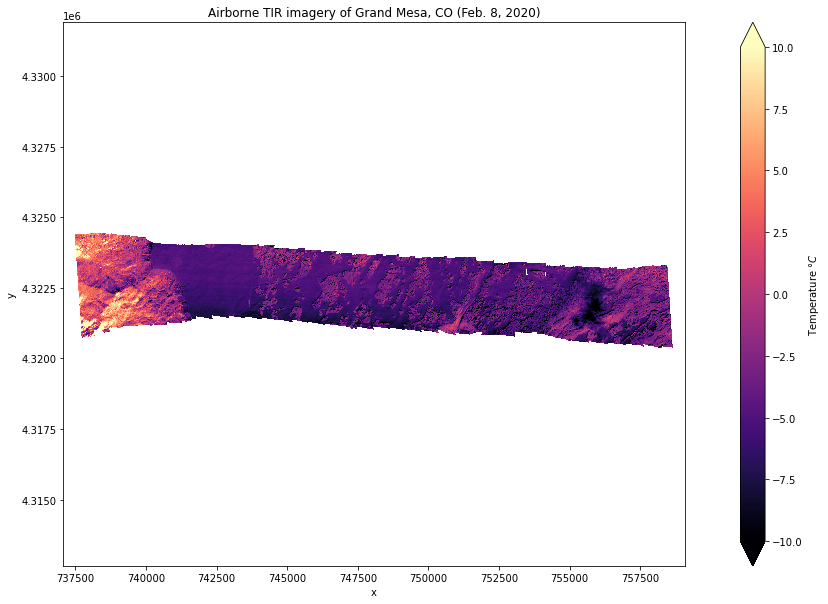

In [6]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10,ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

ax.set_title('Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

---

**Point timeseries to help ground truth the airborne ir data**

To provide a source of "ground truth" for the airborne and satellite thermal infrared images during the SnowEx 2020 Grand Mesa IOP, we can use ground-based snow surface temperature measurements. On February 5, 2020, we installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10 (left), and buried temperature sensors beneath the snow surface (right). These logged observations at 5-minute intervals until we removed the instrumentation a week later on February 12.



<figure>
  <img src="figures/snowpit_2s10.png" width="600"/>
  <figcaption>Snow temperature sensor setup at snow pit 2S10: (left) tripod-mounted thermal ifrared radiometer to measure snow surface, (right) temperature probes to be burried beneath the snow surface.<br/>(Photos by Steven Pestana)</figcaption>
</figure>

What are the differences we might expect to see between the ground point and the thermal IR data?
 - our ground based radiometer was looking at 45 deg off nadir, versus nadir ASTER versus variable view angle airborne (snow emissivity changes off-nadir)
 - band-width of the radiometer versus the airborne camera versus ASTER and spectral response functions
 - atmospheric path length (from < 1 meter, to 1 km, to whole atmosphere) (wind-blown snow aloft?)
 - "point" (actually some weighted value of a small ellipse on the ground) versus pixels of different sizes, their own point spread functions, and geolocation accuracy
 
 ---

**Where is snow pit 2S10?**

We can find this information through a query to the SnowEx SQL database. First, set up the connection:

In [7]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

Then, query [SiteData](https://snowexsql.readthedocs.io/en/latest/database_structure.html#sites-table) using [filter_by](https://docs.sqlalchemy.org/en/14/orm/query.html#sqlalchemy.orm.Query.filter_by) to find the entry with the site ID that we want.

In [8]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

# Preview the resulting geopandas dataframe
siteData_df

,site_name,date,time_created,time_updated,id,site_id,doi,date_accessed,latitude,longitude,...,weather_description,precip,sky_cover,wind,ground_condition,ground_roughness,ground_vegetation,vegetation_height,tree_canopy,site_notes
0,Grand Mesa,2020-02-05,2021-06-01 18:41:44.586420+00:00,None,115,2S10,https://doi.org/10.5067/DUD2VZEVBJ7S,None,39.019474,-108.192314,...,"Sunny and cold, some blowing snow",None,Few (< 1/4 of sky),Moderate,Frozen,Rough,"Grass, Shrub","20, 30",No Trees,None


We can now plot our snow pit site from this [geodataframe](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.plot.html) on top of the airborne IR image. (See more tips about plotting geodataframes [here](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/))



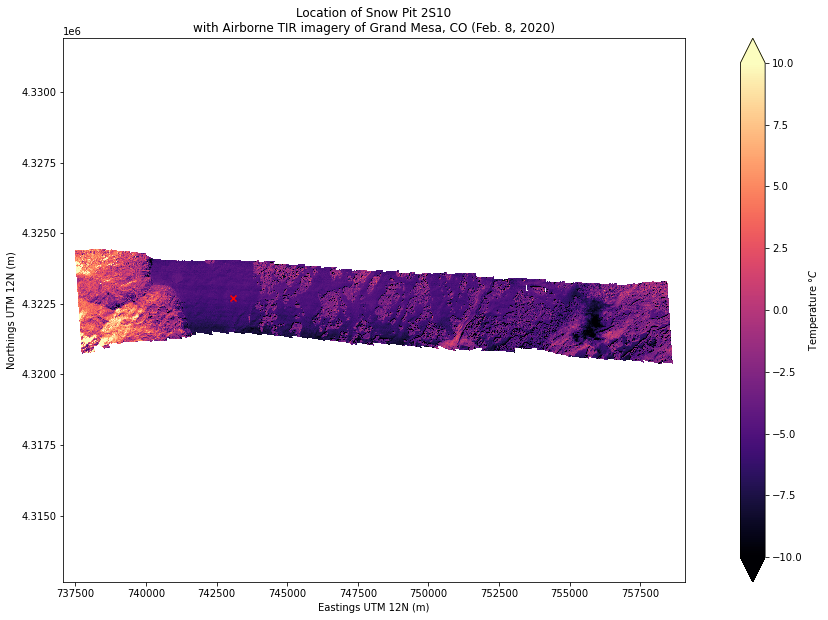

In [9]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set plot title
ax.set_title('Location of Snow Pit 2S10\nwith Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

Change the x and y axes limits ([set_xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html), and [set_ylim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)) to zoom in to our point of interest. In this case we can use [df.geometry.total_bounds](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.total_bounds.html) to get the x and y values that define the area our geometry takes up. (In this case we have a point so it will return just the point's location, but this would work if we had a polygon as well)

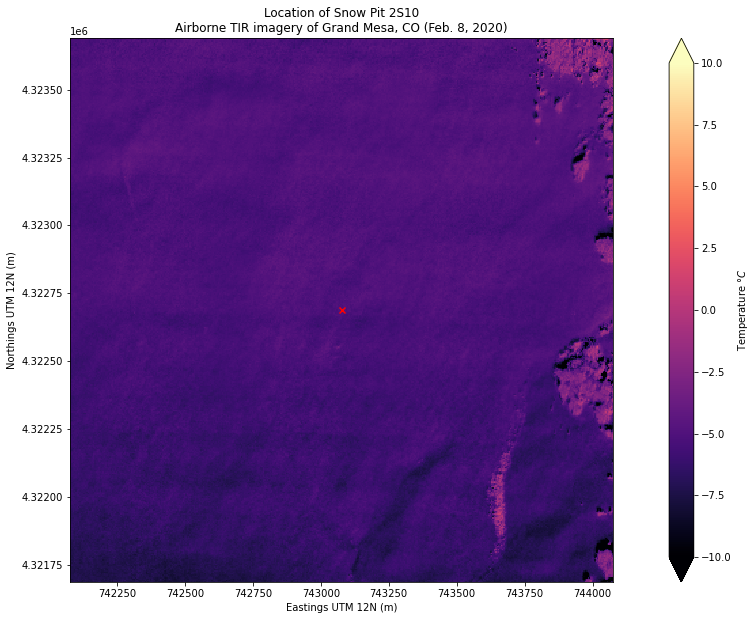

In [10]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# set axes limits
xmin, ymin, xmax, ymax = siteData_df.geometry.total_bounds # get the "total bounds" for our geometry
ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set plot title
ax.set_title('Location of Snow Pit 2S10\nAirborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

**What is the temperature at this point in the airborne IR image?**

Use rioxarray's [clip](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html) feature to extract the raster values that intersect with the point's geometry. Because we have a point, this will return a single value for the pixel that contains this point.

In [11]:
airborne_ir_point_temperature = airborne_ir.rio.clip(siteData_df.geometry)
airborne_ir_point_temperature

<xarray.DataArray (band: 1, y: 1, x: 1)>
array([[[-5.038153]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.323e+06
  * x            (x) float64 7.431e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     STCtemp
    _FillValue:    nan

What if we add a buffer around this point and get the temperature for a larger area around the snow pit?
https://geopandas.org/docs/reference/api/geopandas.GeoSeries.buffer.html

In [12]:
r = 100 # radius of the buffer in meters (this is in meters because we are working in a UTM coordinate reference system)
siteData_df_buffer = siteData_df.buffer(r)

Clip again

In [13]:
airborne_ir_area_temperature = airborne_ir.rio.clip(siteData_df_buffer.geometry)
airborne_ir_area_temperature

<xarray.DataArray (band: 1, y: 40, x: 40)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.323e+06 4.323e+06 ... 4.323e+06 4.323e+06
  * x            (x) float64 7.43e+05 7.43e+05 7.43e+05 ... 7.432e+05 7.432e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     STCtemp
    _FillValue:    nan

What is the distribution of temperatures at this point?

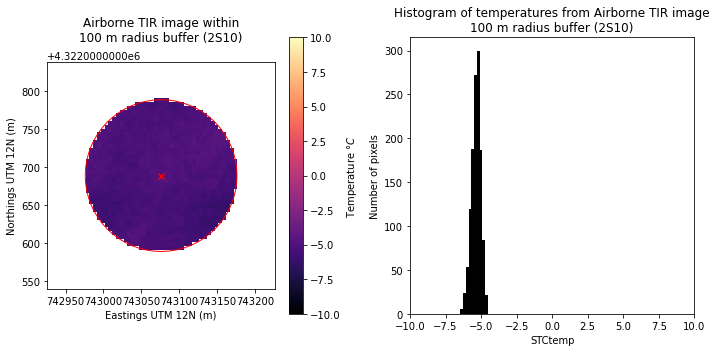

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)

# plot the portion of the airborne TIR image we selected within the buffer area geometry
airborne_ir_area_temperature.plot(cmap='magma', vmin=-10, vmax=10, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('Airborne TIR image within\n100 m radius buffer (2S10)\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color='r', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor='r', facecolor='none')

# plot a histogram of image temperature data within the buffer area geometry
airborne_ir_area_temperature.plot.hist(ax=ax[1], color='k');
ax[1].set_xlim((-10,10)) # set xlim to same values as colorbar in image plot
ax[1].set_title('Histogram of temperatures from Airborne TIR image\n100 m radius buffer (2S10)')
ax[1].set_ylabel('Number of pixels');

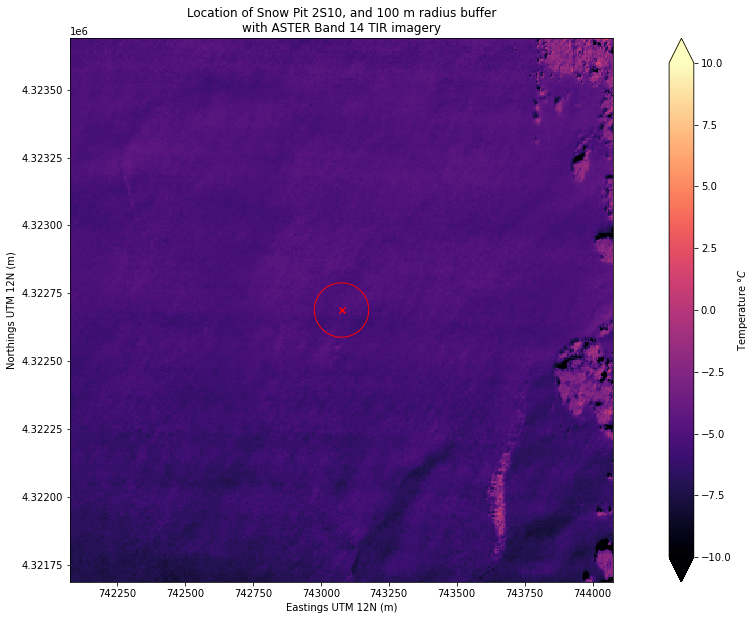

In [15]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10, ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')

# set the same axes limits as above
ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set plot title
ax.set_title('Location of Snow Pit 2S10, and 100 m radius buffer\nwith ASTER Band 14 TIR imagery');

---
Import the snow temperature timeseries dataset

The data file doesn't include the column names, so we need to set the column headers following the dataset's README file.

In [16]:
column_headers = ['table', 'year', 'doy', 'time', # year, day of year, time of day (local time, UTC-7)
                  'rad_avg', 'rad_max', 'rad_min', 'rad_std', # radiometer surface temperature
                  'sb_avg', 'sb_max', 'sb_min', 'sb_std', # radiometer sensor body temperature (for calibration)
                  'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std', # temperature at 5 cm below snow surface
                  'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std', #               10 cm
                  'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std', #               15 cm
                  'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std', #               20 cm
                  'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std', #               30 cm
                  'batt_a','batt_b', # battery voltage data
                 ]

Open the file as a pandas data frame with read_csv

In [17]:
df = pd.read_csv('/tmp/thermal-ir/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat',
                 header = None, names = column_headers)

We need to do some formatting of the data fields, but we can preview what we just loaded fist

In [18]:
df.head() # show the first 5 rows of the dataframe

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt_a,batt_b
0,101,2020,30,1537,22.963,22.963,22.963,0.000,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
1,101,2020,30,1538,22.962,22.963,22.961,0.001,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
2,101,2020,30,1539,25.080,26.810,22.968,1.484,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,24.47,22.83
3,101,2020,30,1540,25.320,25.569,25.133,0.184,22.839,22.846,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,25.42,22.85
4,102,2020,30,1540,12.050,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data cleanup and formatting

In [19]:
# Create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df['time_str'] = [('0' * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])]
# change midnight from '2400' to '0000'
df.time_str.replace('2400', '0000', inplace=True)

Convert year and day of year to pandas datetime index:

In [20]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    '''Compose a datetime object from various datetime components. This clever solusion is from:
        https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas'''
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [21]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

Inspect the contents

In [22]:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


Make a simple plot

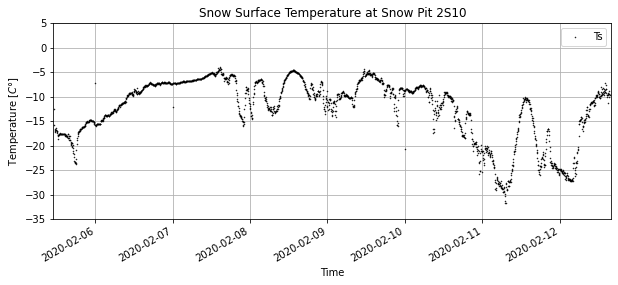

In [23]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='none', marker='.', markersize=1, c='k', label='Ts')

# set axes limits
plt.ylim((-35,5))
plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

:::{admonition} Bonus plot: look at snow temperatures below the snow surface
:class: dropdown 

Add the following to the above plot to add lines for temperature recorded at each depth interval below the snow surface:

```
# plot the snow temperature at each depth it was measured
df.temp1_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.8,0.8,1], label='Ts @ -5 cm')
df.temp2_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.6,0.6,1], label='Ts @ -10 cm')
df.temp3_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.4,0.4,1], label='Ts @ -15 cm')
df.temp4_avg.plot(linestyle='-', marker='.', markersize=1, c=[0.2,0.2,1], label='Ts @ -20 cm')
df.temp5_avg.plot(linestyle='-', marker='.', markersize=1, c=[0,0,1], label='Ts @ -30 cm')
```

:::

But then we want to focus on the date/time when our IR image was from, so zoom in there (data slice or something)
Zoom in on Feb 8th by changing our plot's [xlim](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html).

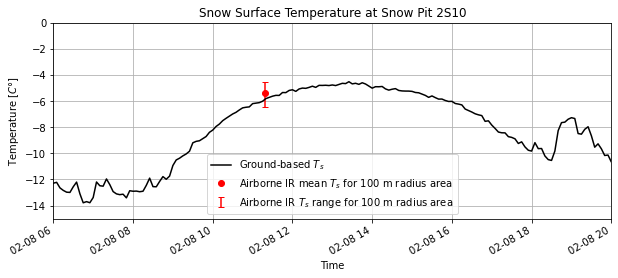

In [24]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
         marker='o', c='r', linestyle='none',
         label='Airborne IR mean $T_s$ for 100 m radius area')

# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
             yerr=[[airborne_ir_area_temperature.mean()-airborne_ir_area_temperature.min()], 
                   [airborne_ir_area_temperature.max()-airborne_ir_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='r',
            label='Airborne IR $T_s$ range for 100 m radius area')


# set axes limits
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

---
We don't always have airplanes with IR, like i said we have satllites that can get us images more often

- lower spatial resolution just because they're further away
- mixed pixel problem, mixing different temperatures and blurring stuff together
- We timed this airborne imagery with ASTER at the same time

Load an ASTER geotiff, inspect the contents

In [25]:
aster_ir = xr.open_rasterio('/tmp/thermal-ir/AST_L1T_00302082020180748_20200209065849_17218_ImageData14.tif')

In [26]:
aster_ir

<xarray.DataArray (band: 1, y: 817, x: 927)>
[757359 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.357e+06 4.356e+06 4.356e+06 ... 4.283e+06 4.283e+06
  * x        (x) float64 6.998e+05 6.998e+05 6.999e+05 ... 7.83e+05 7.831e+05
Attributes:
    transform:      (90.0, 0.0, 699705.0, 0.0, -90.0, 4356585.0)
    crs:            +init=epsg:32612
    res:            (90.0, 90.0)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [27]:
aster_ir.crs

'+init=epsg:32612'

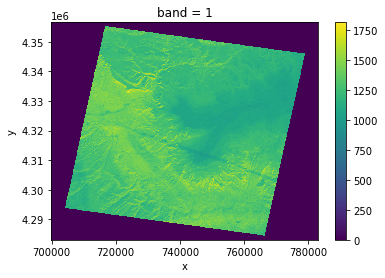

In [28]:
aster_ir.plot()

When was this image taken?

In [29]:
aster_ir_timestamp = pd.Timestamp(2020,2,8,18,7,48) - pd.Timedelta(hours=7)

https://lpdaac.usgs.gov/products/ast_l1tv003/



Show that we can find the following information in the ASTER product documentation:
- which bands/wavelengths we're looking at
  - Band 14: 10.95-11.65 μm
- how to convert from DN to Radiance
- how to convert from Radiance to Tb


Add screenshot/figures

In [30]:
def tir_dn2rad(DN, band):
    '''Convert AST_L1T Digital Number values to At-Sensor Radiance for the TIR bands (bands 10-14).'''
    ucc = [6.822e-3, 6.780e-3, 6.590e-3, 5.693e-3, 5.225e-3]
    rad = (DN-1.) * ucc[band-10]
    return rad

def tir_rad2tb(rad, band):
    '''Convert AST_L1T At-Sensor Radiance to Brightness Temperature [K] for the TIR bands (bands 10-14).'''
    k1 = [3047.47, 2480.93, 1930.80, 865.65, 649.60]
    k2 = [1736.18, 1666.21, 1584.72,1349.82, 1274.49]
    tb = k2[band-10] /  np.log((k1[band-10]/rad) + 1)
    return tb

Convert from DN to radiance, radiance to brightness temperature (assume and emissivity of 1 for all surfaces, note that the airborne imagery also assumed emissivity of 1)

In [31]:
aster_band14_tb_k = tir_rad2tb( tir_dn2rad( aster_ir, band=14 ), band=14 )
aster_band14_tb_c = aster_band14_tb_k - 273.15

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Add the crs back to the dataset

In [32]:
aster_band14_tb_c.rio.set_crs(aster_ir.crs, inplace=True)

<xarray.DataArray (band: 1, y: 817, x: 927)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.357e+06 4.356e+06 4.356e+06 ... 4.283e+06 4.283e+06
  * x        (x) float64 6.998e+05 6.998e+05 6.999e+05 ... 7.83e+05 7.831e+05

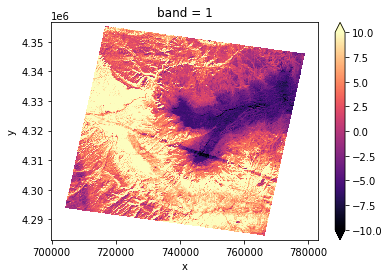

In [33]:
aster_band14_tb_c.plot(cmap='magma',vmin=-10,vmax=10)

Plot ASTER next to Airborne vis and IR to show scale differences



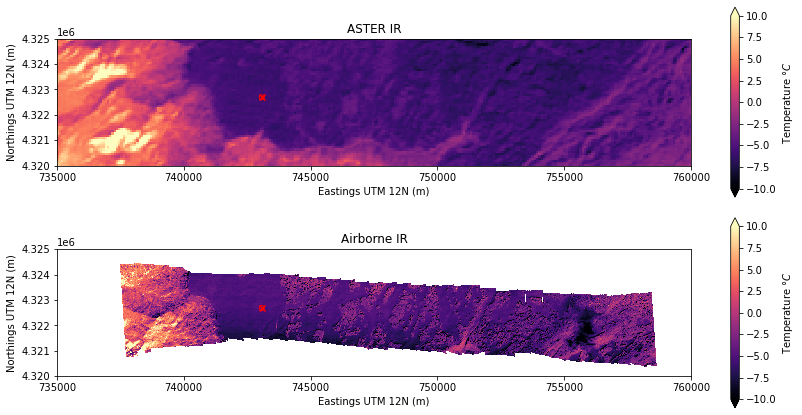

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), tight_layout=True)

aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')


airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')

# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels and limits
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_xlim((735000, 760000))
    ax.set_ylabel('Northings UTM 12N (m)')
    ax.set_ylim((4320000, 4325000))

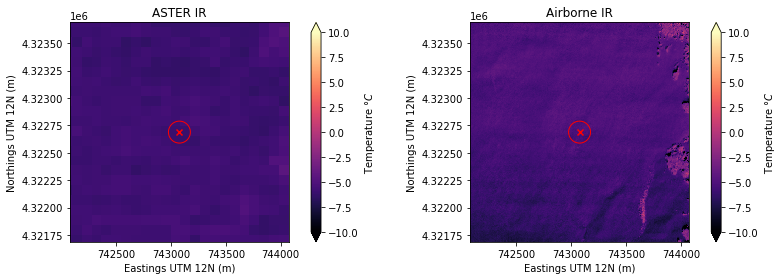

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), tight_layout=True)

aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')


airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')

# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_ylabel('Northings UTM 12N (m)')
    # set the same axes limits as above
    ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
    ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

Grab temperature of ASTER pixel at point and add to timeseries plot

In [36]:
aster_band14_tb_c_point_temperature = aster_band14_tb_c.rio.clip(siteData_df.geometry)
aster_band14_tb_c_area_temperature = aster_band14_tb_c.rio.clip(siteData_df_buffer.geometry)
aster_band14_tb_c_area_temperature

<xarray.DataArray (band: 1, y: 2, x: 2)>
array([[[-6.08382303, -6.1361369 ],
        [-6.0315384 , -6.24085249]]])
Coordinates:
  * y            (y) float64 4.323e+06 4.323e+06
  * x            (x) float64 7.43e+05 7.431e+05
  * band         (band) int64 1
    spatial_ref  int64 0

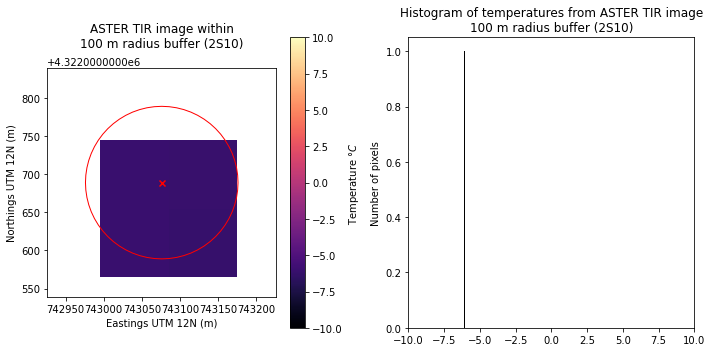

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)

# plot the portion of the airborne TIR image we selected within the buffer area geometry
aster_band14_tb_c_area_temperature.plot(cmap='magma', vmin=-10, vmax=10, ax=ax[0], 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
ax[0].set_title('ASTER TIR image within\n100 m radius buffer (2S10)\n')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Eastings UTM 12N (m)')
ax[0].set_ylabel('Northings UTM 12N (m)')
ax[0].set_xlim((xmin-150, xmax+150)) # x axis limits to +/- 150 m from our point's "total bounds"
ax[0].set_ylim((ymin-150, ymax+150)) # y axis limits to +/- 150 m from our point's "total bounds"

# plot the location of the snow pit of interest to the plot
siteData_df.plot(ax=ax[0], color='r', marker='x')

# plot the area of the buffer we made around the snow pit
siteData_df_buffer.plot(ax=ax[0], edgecolor='r', facecolor='none')

# plot a histogram of image temperature data within the buffer area geometry
aster_band14_tb_c_area_temperature.plot.hist(ax=ax[1], color='k');
ax[1].set_xlim((-10,10)) # set xlim to same values as colorbar in image plot
ax[1].set_title('Histogram of temperatures from ASTER TIR image\n100 m radius buffer (2S10)')
ax[1].set_ylabel('Number of pixels');

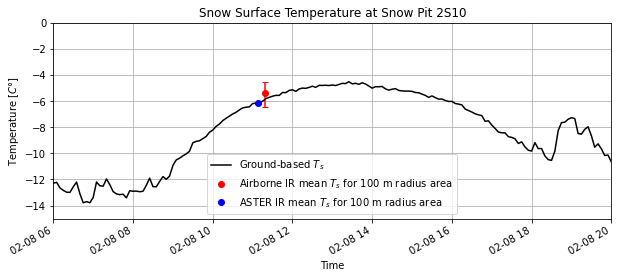

In [38]:
plt.figure(figsize=(10,4))

# plot radiometer average temperature
df.rad_avg.plot(linestyle='-', marker='', markersize=1, c='k', label='Ground-based $T_s$')

# plot the mean airborne IR temperature from the area around the snow pit:
plt.plot(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
         marker='o', c='r', linestyle='none',
         label='Airborne IR mean $T_s$ for 100 m radius area')

# plot an error bar showing the maximum and minimum airborne IR temperature around the snow pit
plt.errorbar(airborne_ir_timestamp, airborne_ir_area_temperature.mean(),
             yerr=[[airborne_ir_area_temperature.mean()-airborne_ir_area_temperature.min()], 
                   [airborne_ir_area_temperature.max()-airborne_ir_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='r',
            )#label='Airborne IR $T_s$ range for 100 m radius area')

# plot the mean ASTER IR temperature from the area around the snow pit:
plt.plot(aster_ir_timestamp, aster_band14_tb_c_area_temperature.mean(),
         marker='o', c='b', linestyle='none',
        label='ASTER IR mean $T_s$ for 100 m radius area')

# plot an error bar showing the maximum and minimum ASTER IR temperature around the snow pit
plt.errorbar(aster_ir_timestamp, aster_band14_tb_c_area_temperature.mean(),
             yerr=[[aster_band14_tb_c_area_temperature.mean()-aster_band14_tb_c_area_temperature.min()], 
                   [aster_band14_tb_c_area_temperature.max()-aster_band14_tb_c_area_temperature.mean()]],
            capsize=3, fmt='none', ecolor='b',
            )#label='ASTER IR $T_s$ range for 100 m radius area')


# set axes limits
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0))) # zoom in to daytime hours on Feb. 8, 2020

# add a legend to the plot
plt.legend()

# set axes labels
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')

# add grid lines to the plot
plt.grid('on')

# set the plot title
plt.title('Snow Surface Temperature at Snow Pit 2S10');

---
### Bonus activity 1:

"upscale" airborne image to the same resolution as ASTER

In [39]:
airborne_ir_repr = airborne_ir.rio.reproject_match(aster_ir, resampling=5)

In [40]:
airborne_ir_repr

<xarray.DataArray (band: 1, y: 817, x: 927)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 6.998e+05 6.998e+05 ... 7.83e+05 7.831e+05
  * y            (y) float64 4.357e+06 4.356e+06 ... 4.283e+06 4.283e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     STCtemp
    _FillValue:    nan

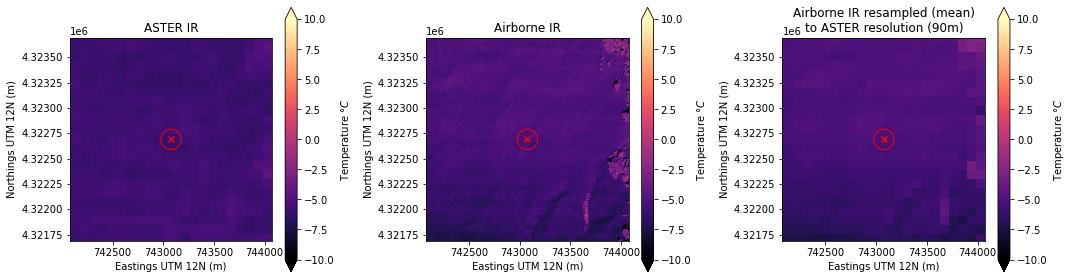

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4), tight_layout=True)


aster_band14_tb_c.plot(ax=axs[0], 
                       cmap='magma', 
                       vmin=-10, vmax=10, 
                       cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('ASTER IR')
axs[0].set_aspect('equal')


airborne_ir.plot(ax=axs[1], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[1].set_title('Airborne IR')
axs[1].set_aspect('equal')


airborne_ir_repr.plot(ax=axs[2], 
                      cmap='magma', 
                      vmin=-10, vmax=10, 
                      cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[2].set_title('Airborne IR resampled (mean)\nto ASTER resolution (90m)')
axs[2].set_aspect('equal')


# for each subplot, do the following:
for ax in axs: 
    ax.set_aspect('equal') # set the aspect ratio to "equal"
    
    # plot the location of the snow pit of interest
    siteData_df.plot(ax=ax, color='r', marker='x')
    # plot the area of the buffer we made around the snow pit
    siteData_df_buffer.plot(ax=ax, edgecolor='r', facecolor='none')
    
    # set axes labels
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_ylabel('Northings UTM 12N (m)')
    # set the same axes limits as above
    ax.set_xlim((xmin-1000, xmax+1000)) # x axis limits to +/- 1 km from our point's "total bounds"
    ax.set_ylim((ymin-1000, ymax+1000)) # y axis limits to +/- 1 km from our point's "total bounds"

---
### Bonus activity 2:

Load the visible imagery from the aircraft and plot alongside the thermal infrared imagery. 

In [42]:
airborne_vis = rioxarray.open_rasterio('data/SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')

In [43]:
airborne_vis

<xarray.DataArray (band: 1, y: 3848, x: 4398)>
[16923504 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
  * y            (y) float64 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     SRGB

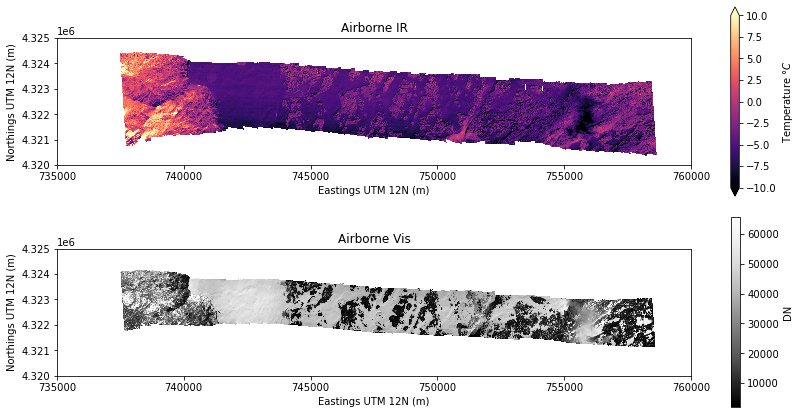

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), tight_layout=True)

airborne_ir.plot(ax=axs[0], 
                 cmap='magma', 
                 vmin=-10, vmax=10, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})
axs[0].set_title('Airborne IR')
axs[0].set_aspect('equal')


airborne_vis.plot(ax=axs[1], 
                  cmap='Greys_r',
                  cbar_kwargs={'label': 'DN'})
axs[1].set_title('Airborne Vis')
axs[1].set_aspect('equal')

for ax in axs:
    ax.set_xlabel('Eastings UTM 12N (m)')
    ax.set_xlim((735000, 760000))
    ax.set_ylabel('Northings UTM 12N (m)')
    ax.set_ylim((4320000, 4325000))

---
---
### **Bonus Notebook**
- Data access/download through EarthdataAPI